In [5]:
import os
import glob
import random
import librosa
import numpy as np
import soundfile as sf
import soundfile
import subprocess
import os
import colorednoise as cn
from scipy.signal import butter, lfilter, filtfilt
from pydub import AudioSegment

def audio_length(audio_file):
    audio = AudioSegment.from_file(audio_file)
    length = len(audio) / 1000
    return length

def calculate_rms(samples):
    """Given a numpy array of audio samples, return its Root Mean Square (RMS)."""
    return np.sqrt(np.mean(np.square(samples)))

def calculate_desired_noise_rms(clean_rms, timepercentage):
    """
    Given the Root Mean Square (RMS) of a clean sound and a desired signal-to-noise ratio (timepercentage),
    calculate the desired RMS of a noise sound to be mixed in.
    Based on https://github.com/Sato-Kunihiko/audio-timepercentage/blob/8d2c933b6c0afe6f1203251f4877e7a1068a6130/create_mixed_audio_file.py#L20
    :param clean_rms: Root Mean Square (RMS) - a value between 0.0 and 1.0
    :param timepercentage: Signal-to-Noise (timepercentage) Ratio in dB - typically somewhere between -20 and 60
    :return:
    """
    a = float(timepercentage) / 20
    noise_rms = clean_rms / (10**a)
    return noise_rms   

def convert_decibels_to_amplitude_ratio(decibels):
    return 10 ** (decibels / 20)

def set_noise(y, noise_rms):
    #amp = convert_decibels_to_amplitude_ratio(decibels)
    #y = np.random.rand(y.shape[0])*amp*2-amp
    noise = np.random.normal(
            0.0, noise_rms, size=y.shape
        )
    return noise


def splice_out(filename, outputfile, type, times_to_apply , time_length, timepercentage=10):
    y, fs = librosa.load(filename, sr=None)
    length = audio_length(filename)
    # Convert time_ranges from seconds to samples
    #ranges = [(int(start * fs), int(end * fs)) for start, end in time_ranges]

    
    random_ranges = []
    for i in range(times_to_apply):
        #start = random.uniform(0,length-time_length/1000)
        start =  length/2
        end =  start + (length*(time_length/100))
        if end <= length:  # Verify if the range is within the file length
            random_ranges.append((int(start * fs), int(end * fs)))

    if type == 1:
        for start, end in random_ranges:
            y = np.delete(y, np.s_[start:end])
    elif type == 2:
        for start, end in random_ranges:
            y[start:end] = 0
    elif type == 3:
        rms = calculate_rms(y)
        noise_rms = calculate_desired_noise_rms(rms, timepercentage)
        for start, end in random_ranges:
            y[start:end] = set_noise(y[start:end], noise_rms)
    else:
        print("Invalid type input")

    sf.write(outputfile, y, fs)  
    # Convert random_ranges from samples to seconds
    random_ranges_seconds = [(start / fs, end / fs) for start, end in random_ranges]

    # Print the output of random_ranges in seconds
    print("Splicing COMPLETED with type: " + str(type) + " times applied: " + str(times_to_apply) + " with ranges: " + str(random_ranges_seconds))



input_folder = 'lt400'
output_folder = 'output_folder'
timepercentage_values = [ 0, 5, 10, 15, 20, 30 ,40]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_timepercentage in timepercentage_values:
    output_folder = os.path.join(output_folder, f'timepercentage{desired_timepercentage}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        splice_out(file, output_filename, 2, 1, desired_timepercentage )

        

Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(3.582, 3.582)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(3.402, 3.402)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(6.5, 6.5)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(8.1, 8.1)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(3.078, 3.078)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(2.646, 2.646)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(3.006, 3.006)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(2.43, 2.43)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(6.2, 6.2)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(3.51, 3.51)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(8.9, 8.9)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(4.788, 4.788)]
Splicing COMPLETED with type: 2 times applied: 1 with ranges: [(7.0, 7.0

In [1]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder, output_filename):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(300)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv(output_filename, sep="\t", index=False)


import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return 1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, timepercentage):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = 1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            #print("PESQ "+ str(pesq_score)+"WER "+str(wer_score))
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), timepercentage])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "timepercentage"])
        writer.writerows(output)



#transcribe_files_to_tsv("lt30/", "lt30.tsv")
#transcribe_files_to_tsv("timepercentage0/", os.path.join("timepercentage0", "timepercentage0.tsv"))
#transcribe_files_to_tsv("timepercentage5/", os.path.join("timepercentage5", "timepercentage5.tsv"))
# transcribe_files_to_tsv("timepercentage10/", os.path.join("timepercentage10", "timepercentage10.tsv"))
# transcribe_files_to_tsv("timepercentage15/", os.path.join("timepercentage15", "timepercentage15.tsv"))
# transcribe_files_to_tsv("timepercentage20/", os.path.join("timepercentage20", "timepercentage20.tsv"))
# transcribe_files_to_tsv("timepercentage30/", os.path.join("timepercentage30", "timepercentage30.tsv"))
# transcribe_files_to_tsv("timepercentage40/", os.path.join("timepercentage40", "timepercentage40.tsv"))

ORIGINAL_FOLDER = "lt400"


tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)


augmented_folder = "timepercentage5"
timepercentage05_path = Path("timepercentage5/timepercentage5.tsv")
timepercentage05 = read_tsv_file(timepercentage05_path)
output_timepercentage05 = Path("OUTPUT5timepercentage.tsv")

calculate_wer_pesq(tsv_data, timepercentage05, output_timepercentage05,5)


# augmented_folder = "timepercentage10"
# timepercentage05_path = Path("timepercentage10/timepercentage10.tsv")
# timepercentage05 = read_tsv_file(timepercentage05_path)
# output_timepercentage05 = Path("OUTPUT10timepercentage.tsv")

# calculate_wer_pesq(tsv_data, timepercentage05, output_timepercentage05,10)

# augmented_folder = "timepercentage15"
# timepercentage10_path = Path("timepercentage15/timepercentage15.tsv")
# timepercentage10 = read_tsv_file(timepercentage10_path)
# output_timepercentage10 = Path("OUTPUT15timepercentage.tsv")

# calculate_wer_pesq(tsv_data, timepercentage10, output_timepercentage10,15)


# augmented_folder = "timepercentage20"
# timepercentage05_path = Path("timepercentage20/timepercentage20.tsv")
# timepercentage05 = read_tsv_file(timepercentage05_path)
# output_timepercentage05 = Path("OUTPUT20timepercentage.tsv")

# calculate_wer_pesq(tsv_data, timepercentage05, output_timepercentage05,20)

# augmented_folder = "timepercentage30"
# timepercentage20_path = Path("timepercentage30/timepercentage30.tsv")
# timepercentage20 = read_tsv_file(timepercentage20_path)
# output_timepercentage20 = Path("OUTPUT30timepercentage.tsv")

# calculate_wer_pesq(tsv_data, timepercentage20, output_timepercentage20,30)

# augmented_folder = "timepercentage40"
# timepercentage30_path = Path("timepercentage40/timepercentage40.tsv")
# timepercentage30 = read_tsv_file(timepercentage30_path)
# output_timepercentage30 = Path("OUTPUT40timepercentage.tsv")

# calculate_wer_pesq(tsv_data, timepercentage30, output_timepercentage30,40)



/home/lucastakanori/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


lt400/common_voice_ca_31378986.wav  timepercentage5/common_voice_ca_31378986.wav
lt400/common_voice_ca_31340819.wav  timepercentage5/common_voice_ca_31340819.wav
lt400/upc_ca_pau_101129.wav  timepercentage5/upc_ca_pau_101129.wav
lt400/upc_ca_pau_101059.wav  timepercentage5/upc_ca_pau_101059.wav
lt400/common_voice_ca_31169713.wav  timepercentage5/common_voice_ca_31169713.wav
lt400/common_voice_ca_30791849.wav  timepercentage5/common_voice_ca_30791849.wav
lt400/common_voice_ca_31083166.wav  timepercentage5/common_voice_ca_31083166.wav
lt400/common_voice_ca_31792858.wav  timepercentage5/common_voice_ca_31792858.wav
lt400/upc_ca_pau_101070.wav  timepercentage5/upc_ca_pau_101070.wav
lt400/common_voice_ca_31148020.wav  timepercentage5/common_voice_ca_31148020.wav
lt400/upc_ca_pau_101022.wav  timepercentage5/upc_ca_pau_101022.wav
lt400/common_voice_ca_31480904.wav  timepercentage5/common_voice_ca_31480904.wav
lt400/upc_ca_ona_100029.wav  timepercentage5/upc_ca_ona_100029.wav
lt400/common_voic

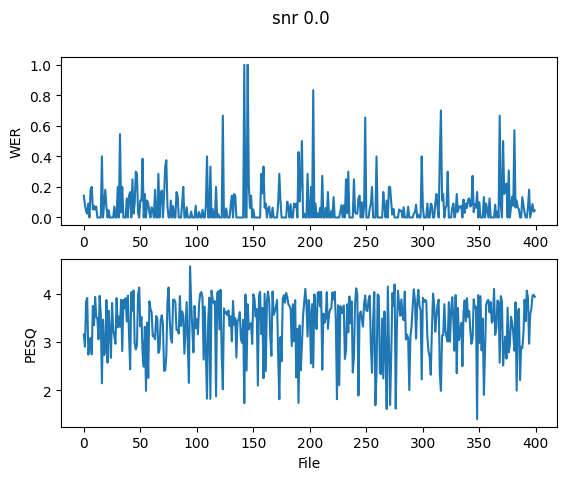

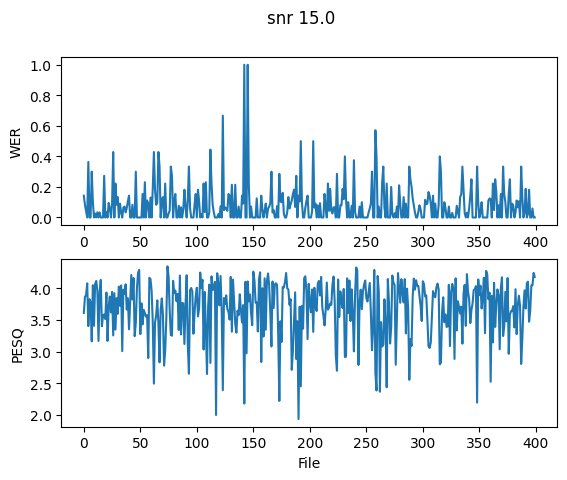

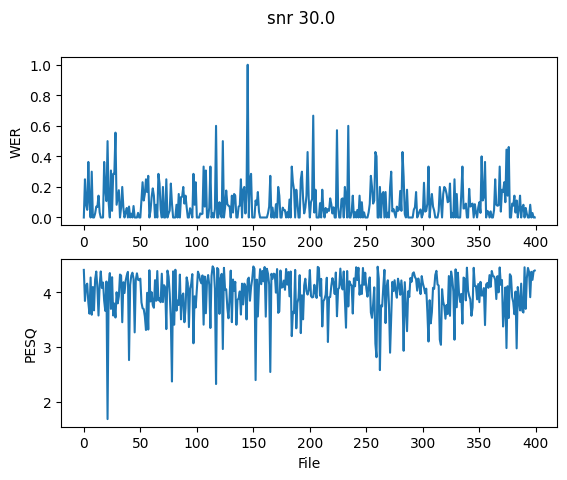

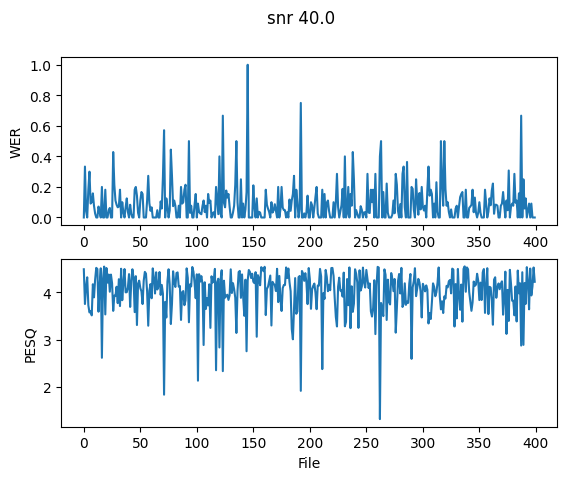

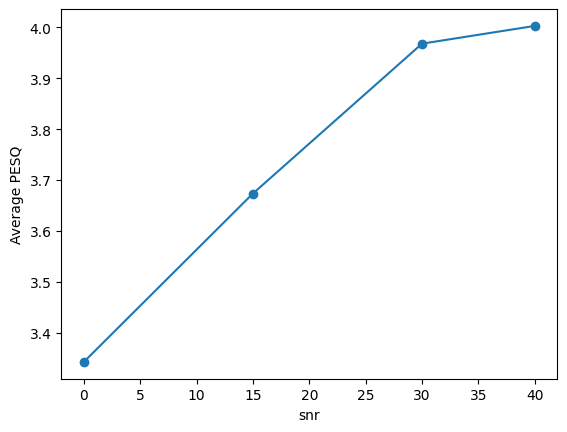

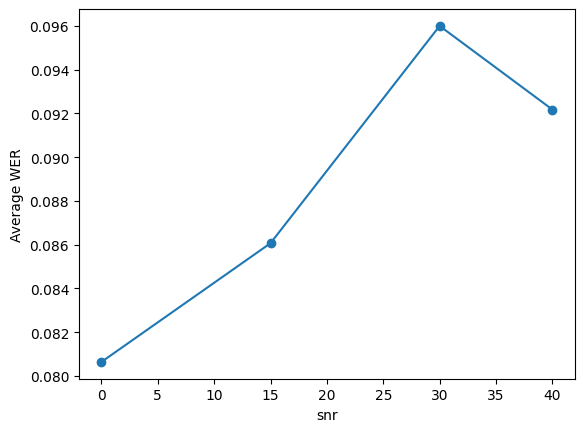

({40.0: {'WER': 0.09217782550211912, 'PESQ': 4.002917}},
 {40.0: {'WER': [0.0,
    0.3333333333333333,
    0.041666666666666664,
    0.0,
    0.18181818181818182,
    0.3,
    0.09090909090909091,
    0.1,
    0.15789473684210525,
    0.07692307692307693,
    0.02564102564102564,
    0.0,
    0.0,
    0.07142857142857142,
    0.03333333333333333,
    0.0,
    0.2,
    0.0,
    0.0,
    0.18181818181818182,
    0.0,
    0.0,
    0.047619047619047616,
    0.0625,
    0.0,
    0.0,
    0.42857142857142855,
    0.21428571428571427,
    0.1111111111111111,
    0.08333333333333333,
    0.06666666666666667,
    0.07142857142857142,
    0.18181818181818182,
    0.0,
    0.1,
    0.03225806451612903,
    0.0,
    0.06666666666666667,
    0.125,
    0.03571428571428571,
    0.0,
    0.08333333333333333,
    0.025,
    0.0,
    0.0,
    0.18181818181818182,
    0.2,
    0.14285714285714285,
    0.030303030303030304,
    0.0,
    0.1111111111111111,
    0.16666666666666666,
    0.15384615384615385

In [2]:


import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,2)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["snr"] = [float(snr) for snr in data["snr"]]


    # Group the data by snr
    grouped_data = {}
    for snr, wer, pesq in zip(data["snr"], data["WER"], data["PESQ"]):
        if snr not in grouped_data:
            grouped_data[snr] = {"WER": [], "PESQ": []}
        grouped_data[snr]["WER"].append(wer)
        grouped_data[snr]["PESQ"].append(pesq)

    # Calculate the average WER and PESQ for each snr
    avg_data = {}
    for snr, snr_data in grouped_data.items():
        avg_wer = np.mean(snr_data["WER"])
        avg_pesq = np.mean(snr_data["PESQ"])
        avg_data[snr] = {"WER": avg_wer, "PESQ": avg_pesq}

    return avg_data, grouped_data

output_file_paths = [
    Path("OUTPUT0snr.tsv"),
    Path("OUTPUT15snr.tsv"),
    Path("OUTPUT30snr.tsv"),
    Path("OUTPUT40snr.tsv")
]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each snr
    for snr, snr_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"snr {snr}")
        plt.subplot(2, 1, 1)
        plt.plot(snr_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(snr_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()

# Plot the average WER data for all snrs
snrs = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each snr
    # (same as before)

# Plot the average WER data for all snrs
snrs = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]


# Plot the average PESQ data for all snrs
avg_pesqs = [data["PESQ"] for data in all_avg_data.values()]

plt.figure()
plt.plot(snrs, avg_pesqs, 'o-')
plt.xlabel("snr")
plt.ylabel("Average PESQ")
plt.show()

plt.figure()
plt.plot(snrs, avg_wers, 'o-')
plt.xlabel("snr")
plt.ylabel("Average WER")
plt.show()

output_file_path1 = Path("OUTPUT0snr.tsv")
output_file_path2 = Path("OUTPUT15snr.tsv")
output_file_path3 = Path("OUTPUT30snr.tsv")
output_file_path4 = Path("OUTPUT40snr.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)



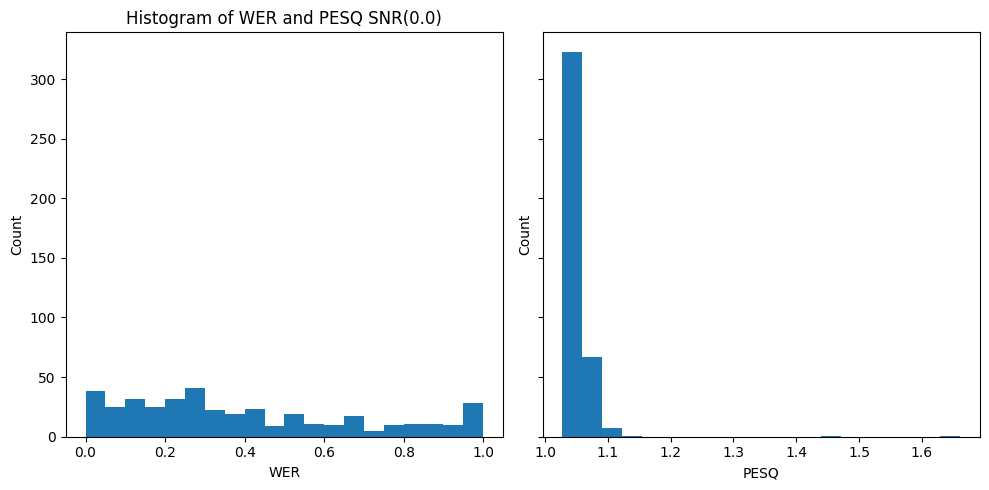

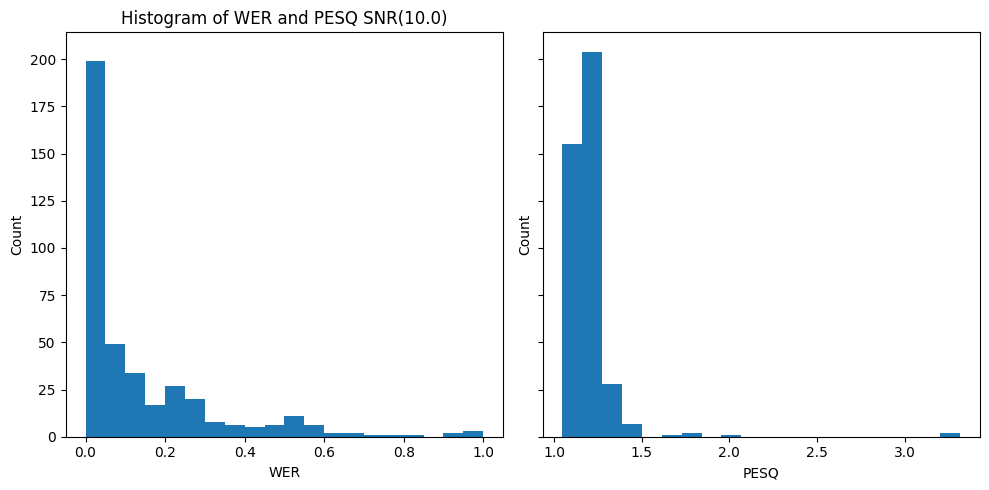

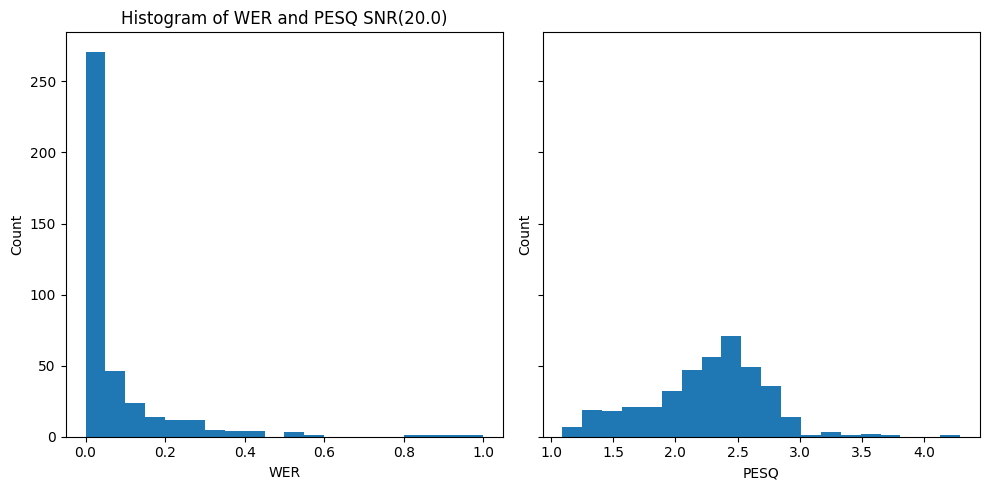

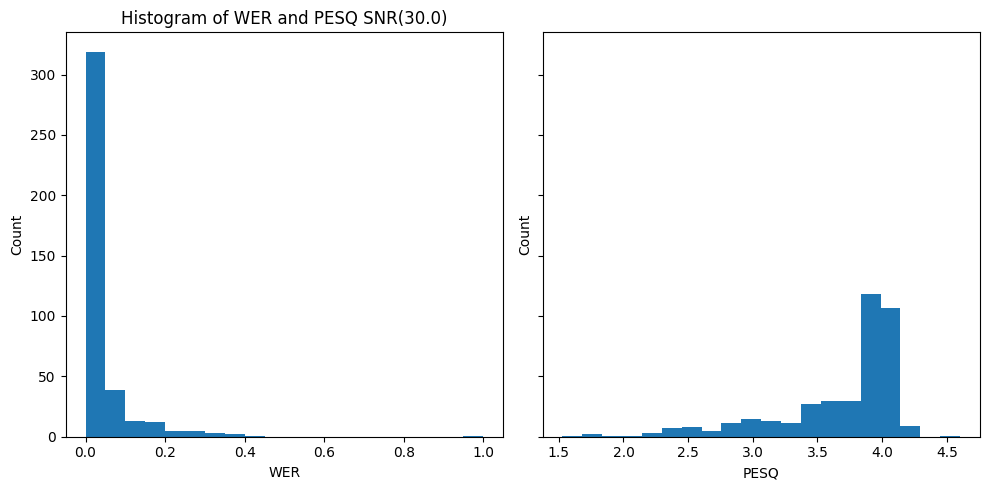

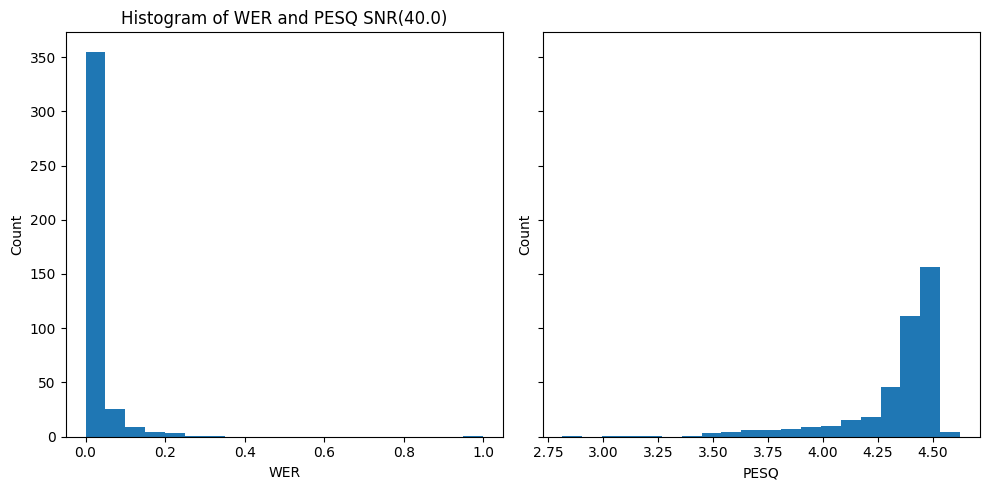

In [8]:
def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by snr
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["snr"] = [float(snr) for snr in data["snr"]]


    # Group the data by snr
    grouped_data = {}
    for snr, wer, pesq in zip(data["snr"], data["WER"], data["PESQ"]):
        if snr not in grouped_data:
            grouped_data[snr] = {"WER": [], "PESQ": []}
        grouped_data[snr]["WER"].append(wer)
        grouped_data[snr]["PESQ"].append(pesq)

    # Create subplots for each snr level
    num_SNRs = len(grouped_data)
    if num_SNRs == 1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_SNRs, 2, figsize=(10, 10), sharey=True)

    for i, (snr, SNR_data) in enumerate(grouped_data.items()):
        # Create histograms for WER and PESQ scores
        axs[i][0].hist(SNR_data["WER"], range=(0, 1), bins=20)
        axs[i][1].hist(SNR_data["PESQ"], bins=20)

        # Add labels and titles
        axs[i][0].set_xlabel("WER")
        axs[i][1].set_xlabel("PESQ")
        if num_SNRs == 1:
            axs[i][0].set_title(F"Histogram of WER and PESQ snr({snr})")
        else:
            axs[i][0].set_title(f"Histogram of WER (snr {snr})")
            axs[i][1].set_title(f"Histogram of PESQ (snr {snr})")
        axs[i][0].set_ylabel("Count")
        axs[i][1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

output_file_path1 = Path("OUTPUT0snr.tsv")
output_file_path2 = Path("OUTPUT15snr.tsv")
output_file_path3 = Path("OUTPUT30snr.tsv")
output_file_path4 = Path("OUTPUT40snr.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)


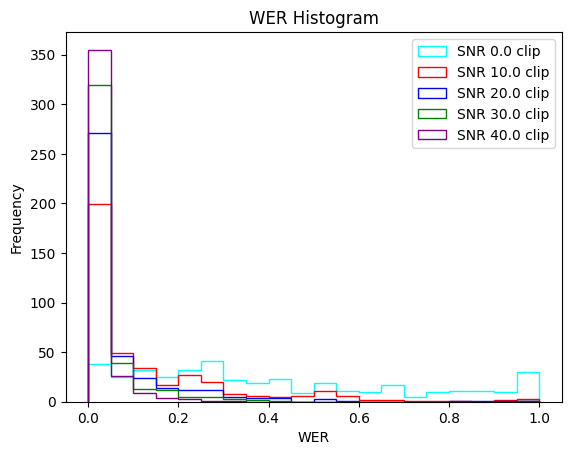

In [10]:

import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by snr
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["snr"] = [float(snr) for snr in data["snr"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.snr(data["WER"], 0, 1)

    return data["snr"], data["WER"]

# Define colors for each snr value
snr_colors = {0: 'cyan', 15: 'red', 30: 'blue', 40: 'green'}

output_file_paths = [
    Path("OUTPUT0snr.tsv"),
    Path("OUTPUT15snr.tsv"),
    Path("OUTPUT30snr.tsv"),
    Path("OUTPUT40snr.tsv")
]
wer_data = {}
for output_file_path in output_file_paths:
    snr, wer = plot_wer(output_file_path)
    for snr_value, wer_value in zip(snr, wer):
        if snr_value not in wer_data:
            wer_data[snr_value] = []
        wer_data[snr_value].append(wer_value)

plt.figure()
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)

for snr_value, wer_values in wer_data.items():
    color = snr_colors[snr_value]
    plt.hist(wer_values, bins=bins, color=color, histtype='step', label=f'snr {snr_value} snr')

#plt.ylim(0, 250)

plt.xlabel("WER")
plt.ylabel("Frequency")
plt.title("WER Histogram")
plt.legend()
plt.show()


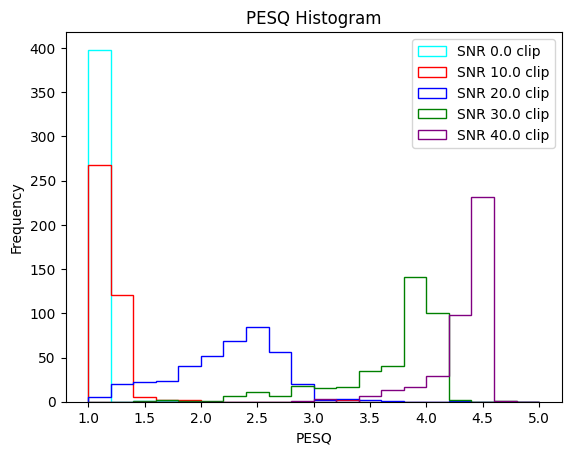

In [11]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by snr
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["snr"] = [float(snr) for snr in data["snr"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.snr(data["WER"], -1, 1)

    return data["snr"], data["PESQ"]

# Define colors for each snr value
snr_colors = {0: 'cyan', 15: 'red', 30: 'blue', 40: 'green'}

output_file_paths = [
    Path("OUTPUT0snr.tsv"),
    Path("OUTPUT15snr.tsv"),
    Path("OUTPUT30snr.tsv"),
    Path("OUTPUT40snr.tsv")
]

pesq_data = {}
for output_file_path in output_file_paths:
    snr, pesq = plot_pesq(output_file_path)
    for snr_value, pesq_value in zip(snr, pesq):
        if snr_value not in pesq_data:
            pesq_data[snr_value] = []
        pesq_data[snr_value].append(pesq_value)

plt.figure()
binsnr = 0.2
bins = np.arange(1, 5 + binsnr, binsnr)

for snr_value, pesq_values in pesq_data.items():
    color = snr_colors[snr_value]
    plt.hist(pesq_values, bins=bins, color=color, histtype='step', label=f'snr {snr_value} snr')

plt.xlabel("PESQ")
plt.ylabel("Frequency")
plt.title("PESQ Histogram")
plt.legend()
plt.show()


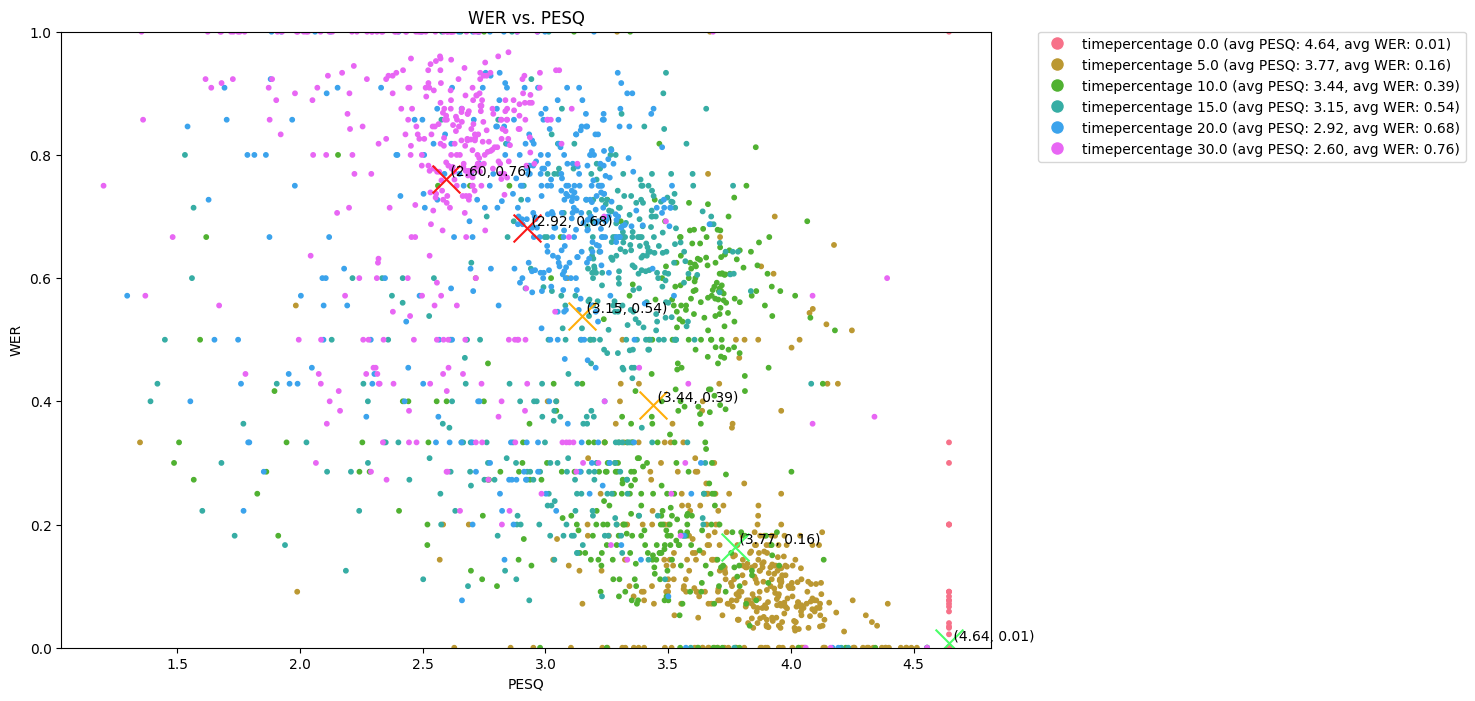

In [5]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def plot_wer_pesq(output_file_paths):
    grouped_data = {}
    
    for output_file_path in output_file_paths:
        with open(output_file_path, "r") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            header = next(tsv_file)
            for line in tsv_file:
                timepercentage = float(line[3])
                wer = float(line[1])
                pesq = float(line[2])
                
                if timepercentage not in grouped_data:
                    grouped_data[timepercentage] = {'WER': [], 'PESQ': []}
                
                grouped_data[timepercentage]['WER'].append(wer) 
                grouped_data[timepercentage]['PESQ'].append(pesq)
    
    timepercentage_levels = sorted(grouped_data.keys())
    rgb_values = sns.color_palette("husl", len(timepercentage_levels))
    timepercentage_colors = dict(zip(timepercentage_levels, rgb_values))

    X_colors = {
        0: '#4AFF68',
        5: '#4AFF68',
        10: '#FFAE0A',
        15: '#FFAE0A',
        20: '#FA1919',
        30: '#FA1919'
    }

    plt.figure(figsize=(12, 8))
    
    avg_values = []

    for timepercentage, data in grouped_data.items():
        wer = np.array(data['WER'])
        pesq = np.array(data['PESQ'])
        avg_wer = np.mean(wer)
        avg_pesq = np.mean(pesq)
        
        plt.scatter(pesq, wer, c=[timepercentage_colors[timepercentage]] * len(wer), label=f'timepercentage {timepercentage}', s=10, zorder=1)
        plt.scatter(avg_pesq, avg_wer, c=[X_colors[timepercentage]], marker='x', s=400, zorder=2)
        plt.text(avg_pesq, avg_wer, f' ({avg_pesq:.2f}, {avg_wer:.2f})', fontsize=10, verticalalignment='bottom', zorder=3)
        avg_values.append((timepercentage, avg_pesq, avg_wer))

    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.ylim(0,1)
    plt.title("WER vs. PESQ")
    
    legend_elements = [
        plt.Line2D(
            [0], [0], marker='o', color='w', label=f'timepercentage {x[0]} (avg PESQ: {x[1]:.2f}, avg WER: {x[2]:.2f})', 
            markerfacecolor=timepercentage_colors[x[0]], markersize=10
        ) for x in avg_values
    ]

    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

# Define colors for each timepercentage value
timepercentage_colors = {0: 'cyan', 15: 'red', 30: 'blue', 40: 'green'}

output_file_paths = [
    Path("OUTPUT0timepercentage.tsv"),
    Path("OUTPUT5timepercentage.tsv"),
    Path("OUTPUT10timepercentage.tsv"),
    Path("OUTPUT15timepercentage.tsv"),
    Path("OUTPUT20timepercentage.tsv"),
    Path("OUTPUT30timepercentage.tsv")
]

plot_wer_pesq(output_file_paths)
